In [1]:
import numpy as np
import gym
import tensorflow as tf
import time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, Input

## Pong
Policy gradient with memory buffer - varying probs to oversample minority (cases when you win), action every 4 frame, and linear annealing

In [2]:
# function to convert each image into lesser size
def prepro(I):
    # preprocess each frame for learning
    # save some memory and computation
    # pre-process the image from a 210x160x3 uint8 frame into an (80x80) float array 
    I = I[35:195,:,:].copy() # crop the top of the image...score image doesn't matter for how to play
    I = I[::2,::2,0].copy()
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return np.array(I.copy())

In [3]:
def discount_rewards(r):
    # take 1D float array of rewards and compute discounted reward
    # gym returns a reward with every single frame.  most of those rewards are 0
    # sometimes they're 1 or -1 if we win or lose a point in that specific frame
    # we want non-0 rewards for every frame. 
    # so take each frame, figure out if we eventually won the corresponding point or not
    # if so make the reward positive, if not negative
    # but more recent actions (relative to the frame where the point is awarded) are more 
    # impactful to the score that frames a long time ago, so discount rewards...
    
    delt = 0.99 # discount factor
    nr = len(r)
    # we want to change all those zeros into discounted values of the next reward (this is the value function!)
    discounted_r = [0.0]*nr
    
    for t in range(nr):
        # start at the end
        if r[nr-t-1] > 0: # if you won a point in this frame we want a good reward
            discounted_r[nr-t-1] = 1
        elif r[nr-t-1] < 0: # if we lost the point we want a bad reward
            discounted_r[nr-t-1] = -1
        elif t==0: # this is just for error catching...at t==0 r[nr-t-1] should have already been + or -...
            discounted_r[nr-t-1] = 0
        elif discounted_r[nr-t-1] == 0: # otherwise you want to look at the next reward value and discount it
            discounted_r[nr-t-1] = delt*discounted_r[nr-t]
    return discounted_r

In [4]:
def create_model(height,width,channels):
    # we cannot simply have 3 output nodes because we want to put a weight on each node's impact to the objective
    # that is different for each data point.  the only way to achieve this is to have 3 output layers, each having 1 node
    # the effect is the same, just the way TF/keras handles weights is different
    imp = Input(shape=(height,width,channels))
    mid = Conv2D(16,(8,8),strides=4,activation='relu')(imp)
    mid = Conv2D(32,(4,4),strides=2,activation='relu')(mid)
    mid = Flatten()(mid)
    mid = Dense(256,activation='relu')(mid)
    out0 = Dense(3,activation='softmax')(mid)
    model = Model(imp,out0) 
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),loss='sparse_categorical_crossentropy')
    
    return model

In [5]:
frames_to_net = 4              # how many previous frames will we feed the NN
possible_actions = [0,2,3]
mod = create_model(80,80,frames_to_net)
mod.call = tf.function(mod.call,experimental_relax_shapes=True)

mod.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 80, 4)]       0         
                                                                 
 conv2d (Conv2D)             (None, 19, 19, 16)        4112      
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 32)          8224      
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 537,651
Trainable params: 537,651
Non-trainable

In [6]:
# linear annealing with same actions for 4 games
def play1game(model, eps):
    env0 = gym.make("Pong-v0")
    pix = env0.reset()
    pix = prepro(pix)
    frames_this_game = 0
    feed = np.zeros((1,80,80,frames_to_net))
    feed[0,:,:,0] = pix.copy()
    
    frame_array = []
    action_array = []
    reward_array = []
    
    score = 0
    done = False
    while not done:
        # updating action every 4 frames
        # but taking that action for the 4 frames just not using the prediction for action
        if frames_this_game % 4 == 0:
            vf = model(feed,training=False).numpy()[0]
            # print(vf)
            if np.random.random() < eps:
                action = np.random.choice(3,p=vf)
                action0 = possible_actions[action]
            else:
                action = np.argmax(vf)
                action0 = possible_actions[action]           
        
        pix_new, reward, done, info = env0.step(action0)
        frame_array.append(pix)
        action_array.append(action)
        reward_array.append(reward)
        pix = prepro(pix_new)
        frames_this_game += 1

        for f in range(1,frames_to_net):
            feed[0,:,:,frames_to_net-f] = feed[0,:,:,frames_to_net-f-1].copy()
        feed[0,:,:,0] = pix.copy()
        score += reward
        
    return frame_array, action_array, reward_array, score

In [7]:
# testing the likelihood of taking each action without any training
frames, actions, rewards, score = play1game(mod,0.5)
print(np.mean(np.array(actions)==0),np.mean(np.array(actions)==1),np.mean(np.array(actions)==2))

0.29831387808041504 0.30609597924773024 0.3955901426718547


In [14]:
# discounting factor
delt = 0.99

# setting up variable for memory buffer
# ngames = 1000
ngames = 5000
nbatch = 10
buffn = 200000
warmupgames = 50
len_buff = 0
buffer = {'frames':[],'actions':[], 'rewards':[]}

# eps vector for each gradient for linear annealing
epsvec = np.linspace(1,0.05,ngames)

In [15]:
output_qdl = {'game':[-1]*ngames, 'score':[-100]*ngames, 'time':[-1]*ngames}

overall_start = time.time()

for game in range(ngames):
    start = time.time()
    frames, actions, rewards, score = play1game(mod, epsvec[game])
    rewards = discount_rewards(rewards.copy())
    buffer['frames'] += frames.copy()
    buffer['actions'] += actions.copy()
    buffer['rewards'] += rewards.copy()
    len_buff += len(actions)
    if len_buff > buffn:
        excess = len_buff - buffn
        buffer['frames'] = buffer['frames'][excess:].copy()
        buffer['actions'] = buffer['actions'][excess:].copy()
        buffer['rewards'] = buffer['rewards'][excess:].copy()
        len_buff = len(buffer['actions'])
    rewards = np.array(rewards)
    actions = np.array(actions)
    nframes = len(frames)
    current_frames = np.zeros((nframes,80,80,frames_to_net))

    if game >= warmupgames:
        # choosing the frames from memory buffer based on the reward
        # weighing the frames 
        # something like over/under sampling in unbalanced class
        prob = np.ones(len_buff)
        prob[np.array(buffer['rewards']) > 0] = 5.0
        prob /= np.sum(prob)
        which_choose = np.random.choice(len_buff,size=nframes,replace=False,p=prob)
    
        for grab in range(nframes):
            rewards[grab] = buffer['rewards'][which_choose[grab]]
            actions[grab] = buffer['actions'][which_choose[grab]]
            for f in range(frames_to_net):
                if grab-f > 0:
                    current_frames[grab,:,:,f] = buffer['frames'][which_choose[grab]-f].copy()
    
        mod.fit(current_frames,actions,epochs=1,steps_per_epoch=nbatch,verbose=0,sample_weight=rewards,use_multiprocessing=True)
    stop = time.time()
    # print(game, score, stop-start,len_buff)

    output_qdl['game'][game] = game
    output_qdl['score'][game] = score
    output_qdl['time'][game] = time
    
    if game % 10 == 0:
        print('Game number ', game, [score, epsvec[game], stop-start], len_buff)

overall_end = time.time()
print('total run time, ', (overall_end - overall_start)/60, 'minutes')

Game number  0 [-21.0, 1.0, 1.6315984725952148] 1268
Game number  10 [-20.0, 0.9980996199239848, 2.2928953170776367] 14343
Game number  20 [-21.0, 0.9961992398479695, 1.7263166904449463] 26642
Game number  30 [-21.0, 0.9942988597719544, 1.3082187175750732] 38444
Game number  40 [-21.0, 0.9923984796959392, 1.4564714431762695] 50784
Game number  50 [-20.0, 0.990498099619924, 2.9567434787750244] 64720
Game number  60 [-21.0, 0.9885977195439087, 2.2193734645843506] 78215
Game number  70 [-20.0, 0.9866973394678936, 3.3297111988067627] 91990
Game number  80 [-21.0, 0.9847969593918784, 2.3014354705810547] 103956
Game number  90 [-21.0, 0.9828965793158632, 2.3114421367645264] 116893
Game number  100 [-21.0, 0.9809961992398479, 2.590679883956909] 129258
Game number  110 [-21.0, 0.9790958191638328, 2.4218432903289795] 142089
Game number  120 [-21.0, 0.9771954390878176, 2.2772791385650635] 154496
Game number  130 [-20.0, 0.9752950590118024, 2.7536120414733887] 167567
Game number  140 [-21.0, 0.97

In [16]:
mod.save('saved_model/pg')

INFO:tensorflow:Assets written to: saved_model/pg\assets


(array([3.973e+03, 0.000e+00, 7.300e+02, 0.000e+00, 2.400e+02, 0.000e+00,
        4.500e+01, 0.000e+00, 1.100e+01, 1.000e+00]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

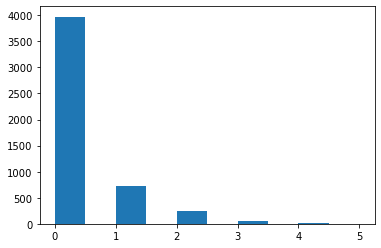

In [17]:
import matplotlib.pyplot as plt
plt.hist([x+21 for x in output_qdl['score']])